In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:

# Load the CSV file and filter numeric columns
df= pd.read_csv(r'preprocced_dataset.csv', low_memory=False)

print(df.columns)
print(df.info())

Index(['OSD.flyTime [s]', 'HOME.distance [ft]', 'OSD.height [ft]',
       'OSD.longitude', 'OSD.latitude', 'OSD.altitude [ft]'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OSD.flyTime [s]     7374 non-null   float64
 1   HOME.distance [ft]  7374 non-null   float64
 2   OSD.height [ft]     7374 non-null   float64
 3   OSD.longitude       7374 non-null   float64
 4   OSD.latitude        7374 non-null   float64
 5   OSD.altitude [ft]   7374 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 345.8 KB
None


In [3]:
feature_columns = df[[ 'OSD.flyTime [s]', 'HOME.distance [ft]', 'OSD.height [ft]']]

target_columns = df[['OSD.longitude', 'OSD.latitude','OSD.altitude [ft]']]

# Initialize the scaler and normalize the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(feature_columns)
y_scaled = scaler_y.fit_transform(target_columns)

In [4]:
# Old sequencing technique (Used in each previous code)

def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length)])
        ys.append(y[i + sequence_length])
    return np.array(Xs), np.array(ys)

#PARAS
sequence_length = 50  #LOOKBACKS
batch_size = 32

#SEQ
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

In [5]:
print(X_seq.shape)
print(y_seq.shape)

(7324, 50, 3)
(7324, 3)


In [6]:
'''# Determine the split indices based on percentage
train_size = int(0.7 * len(X_seq))  # 70% for training
val_size = int(0.15 * len(X_seq))    # 15% for validation

# Train: First 70%
X_train, y_train = X_seq[:train_size], y_seq[:train_size]

# Validation: Next 15% (from train_size to train_size + val_size)
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]

# Test: Final 15% (from train_size + val_size to the end)
X_test, y_test = X_seq[train_size: ], y_seq[train_size:]'''


'# Determine the split indices based on percentage\ntrain_size = int(0.7 * len(X_seq))  # 70% for training\nval_size = int(0.15 * len(X_seq))    # 15% for validation\n\n# Train: First 70%\nX_train, y_train = X_seq[:train_size], y_seq[:train_size]\n\n# Validation: Next 15% (from train_size to train_size + val_size)\nX_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]\n\n# Test: Final 15% (from train_size + val_size to the end)\nX_test, y_test = X_seq[train_size: ], y_seq[train_size:]'

In [7]:
# TRAIN , VALIDATION AND TESTING AREA
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
print(X_test.shape)
print(y_test.shape)

(1099, 50, 3)
(1099, 3)


In [9]:
print("X_train shape:", X_train.shape)  # Should be (num_samples, sequence_length, n_features)
print("y_train shape:", y_train.shape)  # Should be (num_samples, output_dim)

X_train shape: (5126, 50, 3)
y_train shape: (5126, 3)


In [10]:
# Build the LSTM model
def build_model(sequence_length, n_features):
    model = Sequential([
        # First LSTM layer
        LSTM(128, return_sequences=True, input_shape=(sequence_length, n_features)),
        BatchNormalization(),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),

        # Third LSTM layer
        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),

        # Dense layers for prediction
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(3)  # 2 outputs: latitude and longitude and altitute
    ])

    return model

In [11]:
# Get the current directory's path
current_directory = os.getcwd()+ "\\"
# Generate timestamp

timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

# Define the output directory path using the current directory and timestamp
output_dir = os.path.join(current_directory, timestamp)

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

In [12]:
# Define the model checkpoint path within the timestamped directory
model_checkpoint_path = os.path.join(output_dir, "best_lstm_model.keras")

In [13]:
# CALLBACKS (will stop overfitting when patience level reached)
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        model_checkpoint_path,
        # 'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )
]

In [14]:
# Verify shapes
print("X_train shape:", X_train.shape)  # Expected: (num_samples, sequence_length, n_features)
print("y_train shape:", y_train.shape)  # Expected: (num_samples, 2) if predicting latitude and longitude

# Define sequence length and number of features
sequence_length = X_train.shape[1] # Should be set correctly in the dataset
n_features = X_train.shape[2]

# Initialize model with correct dimensions
model = build_model(sequence_length, n_features)
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

X_train shape: (5126, 50, 3)
y_train shape: (5126, 3)


c:\Users\Riya Soni\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:


# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.6747 - mae: 0.6282 - val_loss: 0.0930 - val_mae: 0.2600 - learning_rate: 0.0010
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0727 - mae: 0.2126 - val_loss: 0.0174 - val_mae: 0.1072 - learning_rate: 0.0010
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0332 - mae: 0.1446 - val_loss: 0.0101 - val_mae: 0.0779 - learning_rate: 0.0010
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0231 - mae: 0.1198 - val_loss: 0.0039 - val_mae: 0.0468 - learning_rate: 0.0010
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0195 - mae: 0.1097 - val_loss: 0.0022 - val_mae: 0.0365 - learning_rate: 0.0010
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0151 - mae: 0.0956 - val_loss: 0.0040 - val_mae: 0.0506 - learning_rate: 0.0010
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0131 - mae: 0.0896 - val_loss: 0.0023 - val_mae: 0.0373 - learning_rate:

In [16]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)



In [17]:
print(X_test.shape)
print(y_test.shape)

(1099, 50, 3)
(1099, 3)


In [18]:
print(f'\nTest Loss: {test_loss:.6f}')
print(f'Test MAE: {test_mae:.6f}')


y_pred = model.predict(X_test)

y_test_orig = scaler_y.inverse_transform(y_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)



Test Loss: 0.000325
Test MAE: 0.013930
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [19]:
# ERROR PART
mae_lat = np.mean(np.abs(y_test_orig[:, 0] - y_pred_orig[:, 0]))
mae_lon = np.mean(np.abs(y_test_orig[:, 1] - y_pred_orig[:, 1]))
mae_alt = np.mean(np.abs(y_test_orig[:, 2] - y_pred_orig[:, 1]))
print(f'\nLatitude MAE: {mae_lat:.6f} degrees')
print(f'Longitude MAE: {mae_lon:.6f} degrees')
print(f'Altitute MAE: {mae_alt:.6f} ft')






Latitude MAE: 0.000982 degrees
Longitude MAE: 0.000464 degrees
Altitute MAE: 2980.844001 ft


Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\training_history.png


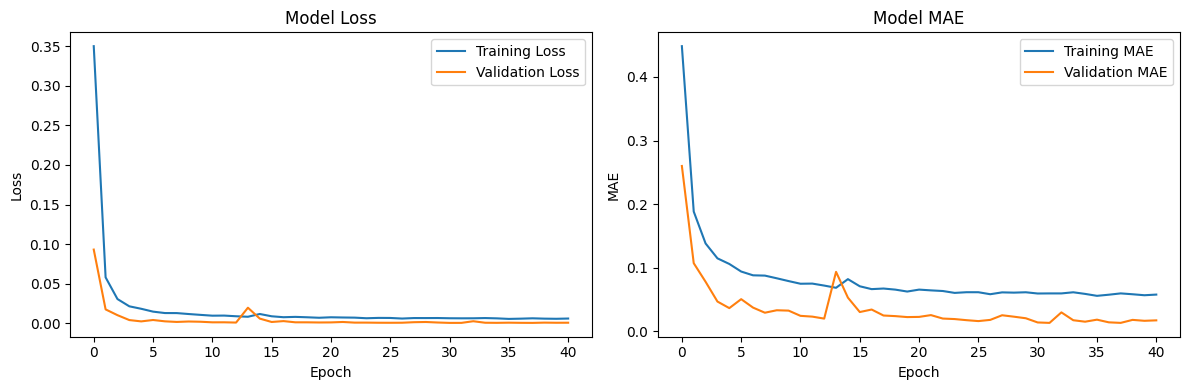

In [20]:
# HISTORY OF EVERY TRAINING PART (PLEASE CHECK THE IMAGES CREATED)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "training_history.png")
plt.savefig(filename)
print(f"Plot saved at {filename}")
plt.show()
################################################

# plt.savefig('training_history.png')
plt.close()


Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results_Latitude.png


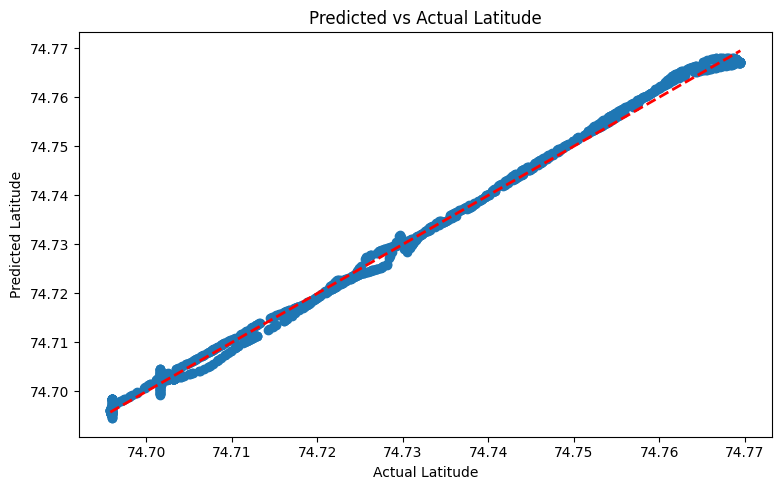

Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results_Longitude.png


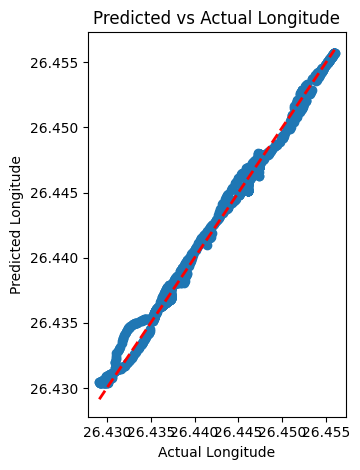

Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results_altitude.png


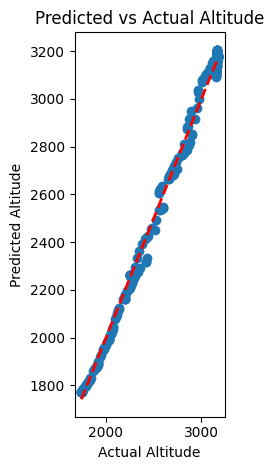

In [35]:
# LATITUDE AND LONGITUDE ( Actul vs Predicted )
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_orig[:, 0], y_pred_orig[:, 0], marker='o')
plt.plot([y_test_orig[:, 0].min(), y_test_orig[:, 0].max()],
         [y_test_orig[:, 0].min(), y_test_orig[:, 0].max()],
         'r--', lw=2)
plt.title('Predicted vs Actual Latitude')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.tight_layout()

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "prediction_results_Latitude.png")
plt.savefig(filename)
print(f"Plot saved at {filename}")
plt.show()
################################################

# plt.savefig('prediction_results_Latitude.png')
plt.close()
plt.subplot(1, 2, 2)
plt.scatter(y_test_orig[:, 1], y_pred_orig[:, 1],marker='o')
plt.plot([y_test_orig[:, 1].min(), y_test_orig[:, 1].max()],
         [y_test_orig[:, 1].min(), y_test_orig[:, 1].max()],
         'r--', lw=2)

plt.title('Predicted vs Actual Longitude')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')

plt.tight_layout()

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "prediction_results_Longitude.png")
plt.savefig(filename)
print(f"Plot saved at {filename}")
plt.show()
################################################

# plt.savefig('prediction_results_Longitude.png')
plt.close()
# Altitude Comparison
plt.subplot(1, 3, 3)
plt.scatter(y_test_orig[:, 2], y_pred_orig[:, 2], marker='o')
plt.plot([y_test_orig[:, 2].min(), y_test_orig[:, 2].max()],
         [y_test_orig[:, 2].min(), y_test_orig[:, 2].max()],
         'r--', lw=2)
plt.title('Predicted vs Actual Altitude')
plt.xlabel('Actual Altitude')
plt.ylabel('Predicted Altitude')

plt.tight_layout()

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "prediction_results_altitude.png")
plt.savefig(filename)
print(f"Plot saved at {filename}")
plt.show()
################################################

# plt.savefig('prediction_results_altitude.png')
plt.close()

Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results_Longitude.png


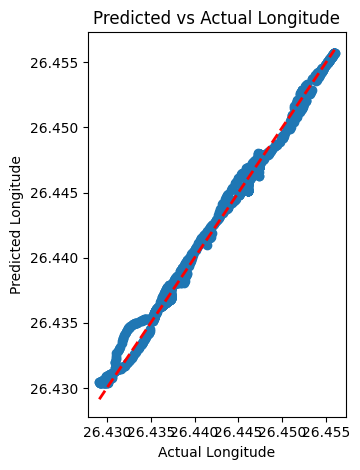

Plot saved at c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results_altitude.png


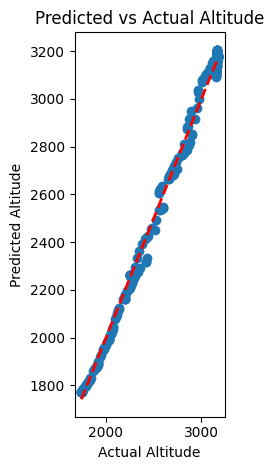

Plot saved as c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\path_comparison.png


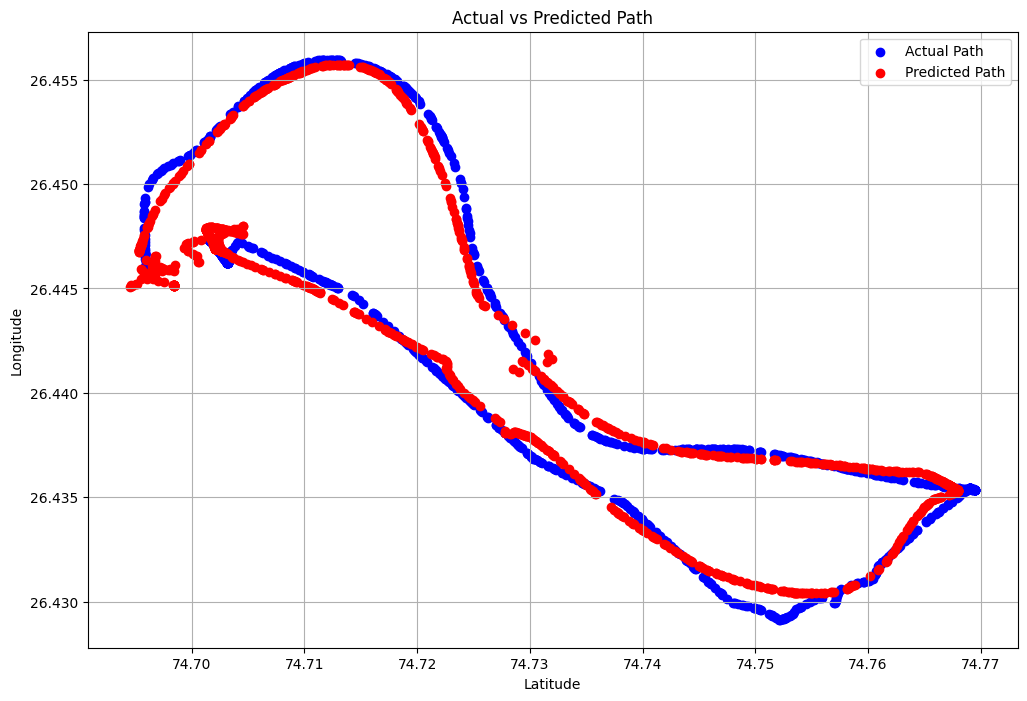

In [24]:
# ACTUAL VS PREDICTED PATH
plt.figure(figsize=(12, 8))
#plt.plot(y_test_orig[:, 1], y_test_orig[:, 0], 'b-', label='Actual Path', alpha=0.7,)
#plt.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], 'r--', label='Predicted Path', alpha=0.7)
plt.scatter(y_test_orig[:, 0],y_test_orig[:, 1], color='b', label='Actual Path',marker='o')
plt.scatter(y_pred_orig[:, 0],y_pred_orig[:, 1], color='r', label='Predicted Path',marker='o')
plt.title('Actual vs Predicted Path')


plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.legend()
plt.grid(True)

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "path_comparison.png")
plt.savefig(filename)
print(f"Plot saved as {filename}")
plt.show()
################################################

# plt.savefig('path_comparison.png')
plt.close()

C:\Users\Riya Soni\AppData\Local\Temp\ipykernel_25428\3265086502.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Plot saved as c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\3D_path_comparison.png


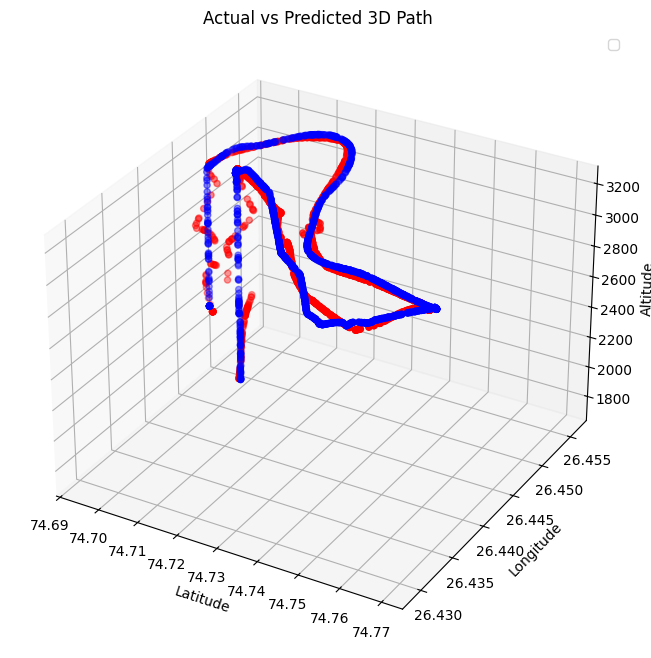

In [25]:
'''# ACTUAL VS PREDICTED PATH
plt.figure(figsize=(12, 8))
#plt.plot(y_test_orig[:, 1], y_test_orig[:, 0], 'b-', label='Actual Path', alpha=0.7,)
#plt.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], 'r--', label='Predicted Path', alpha=0.7)
plt.scatter(y_test_orig[:, 1], y_test_orig[:, 0], color='b', label='Actual Path',marker='o')
plt.scatter(y_pred_orig[:, 1], y_pred_orig[:, 0], color='r', label='Predicted Path',marker='o')
plt.title('Actual vs Predicted Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('path_comparison.png')
plt.close()'''
from mpl_toolkits.mplot3d import Axes3D

# ACTUAL VS PREDICTED 3D PATH
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the actual path
#ax.plot(y_test_orig[:, 1], y_test_orig[:, 0], y_test_orig[:, 2], 'b-', label='Actual Path', alpha=0.7)
ax.scatter(y_test_orig[:, 0],y_test_orig[:, 1], y_test_orig[:, 2], color='b', marker='o')

# Plotting the predicted path
#ax.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], y_pred_orig[:, 2], 'r--', label='Predicted Path', alpha=0.7)
ax.scatter( y_pred_orig[:, 0],y_pred_orig[:, 1], y_pred_orig[:, 2], color='r', marker='o')

# Setting labels and title
ax.set_title('Actual vs Predicted 3D Path')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')

# Adding legend and grid
ax.legend()
ax.grid(True)

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "3D_path_comparison.png")
plt.savefig(filename)
print(f"Plot saved as {filename}")
plt.show()
################################################

# Save the plot
# plt.savefig('3D_path_comparison.png')
plt.close()


In [ ]:


'''# RUN THIS PART IN CASE YOU WANT TO SAVE THE PREDICTION IN A NEW CSV
results_df = pd.DataFrame({
     'Actual_Latitude': y_test_orig[:, 0],
     'Actual_Longitude': y_test_orig[:, 1],
     'Predicted_Latitude': y_pred_orig[:, 0],
     'Predicted_Longitude': y_pred_orig[:, 1],
     'Latitude_Error': np.abs(y_test_orig[:, 0] - y_pred_orig[:, 0]),
     'Longitude_Error': np.abs(y_test_orig[:, 1] - y_pred_orig[:, 1])
 })
results_df.to_csv('prediction_results.csv', index=False)

print("\nPrediction Results Summary:")
print(f"Average Latitude Error: {results_df['Latitude_Error'].mean():.6f} degrees")
print(f"Average Longitude Error: {results_df['Longitude_Error'].mean():.6f} degrees")
print(f"Max Latitude Error: {results_df['Latitude_Error'].max():.6f} degrees")
print(f"Max Longitude Error: {results_df['Longitude_Error'].max():.6f} degrees")'''


Prediction Results Summary:
Average Latitude Error: 0.001184 degrees
Average Longitude Error: 0.000469 degrees
Max Latitude Error: 0.008465 degrees
Max Longitude Error: 0.001841 degrees


In [26]:
# RUN THIS PART IN CASE YOU WANT TO SAVE THE PREDICTION IN A NEW CSV
results_df = pd.DataFrame({
     'Actual_Latitude': y_test_orig[:, 0],
     'Actual_Longitude': y_test_orig[:, 1],
     'Actual_Altitude': y_test_orig[:, 2],
     'Predicted_Latitude': y_pred_orig[:, 0],
     'Predicted_Longitude': y_pred_orig[:, 1],
     'Predicted_Altitude': y_pred_orig[:, 2],
     'Latitude_Error': np.abs(y_test_orig[:, 0] - y_pred_orig[:, 0]),
     'Longitude_Error': np.abs(y_test_orig[:, 1] - y_pred_orig[:, 1]),
     'Altitude_Error': np.abs(y_test_orig[:, 2] - y_pred_orig[:, 2])
})

################################################
# Save the csv with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "prediction_results.csv")
print(f"csv saved as {filename}")

################################################


# Save the DataFrame as a CSV in the new directory
results_df.to_csv(filename, index=False)


# Save to CSV
# results_df.to_csv('prediction_results.csv', index=False)

# Print Summary of Results
print("\nPrediction Results Summary:")
print(f"Average Latitude Error: {results_df['Latitude_Error'].mean():.6f} degrees")
print(f"Average Longitude Error: {results_df['Longitude_Error'].mean():.6f} degrees")
print(f"Average Altitude Error: {results_df['Altitude_Error'].mean():.6f} meters")
print(f"Max Latitude Error: {results_df['Latitude_Error'].max():.6f} degrees")
print(f"Max Longitude Error: {results_df['Longitude_Error'].max():.6f} degrees")
print(f"Max Altitude Error: {results_df['Altitude_Error'].max():.6f} meters")


csv saved as c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\prediction_results.csv

Prediction Results Summary:
Average Latitude Error: 0.000982 degrees
Average Longitude Error: 0.000464 degrees
Average Altitude Error: 15.971917 meters
Max Latitude Error: 0.002965 degrees
Max Longitude Error: 0.002153 degrees
Max Altitude Error: 102.219971 meters


In [ ]:
'''# ACTUAL VS PREDICTED PATH
plt.figure(figsize=(12, 8))
plt.plot(y_test_orig[:, 1], y_test_orig[:, 0], 'b-', label='Actual Path', alpha=0.7)
#plt.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], 'r--', label='Predicted Path', alpha=0.7)
plt.title('Actual  Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('actual.png')
plt.close()'''


C:\Users\Riya Soni\AppData\Local\Temp\ipykernel_25428\3075572384.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Plot saved as c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\actual_3d_path.png


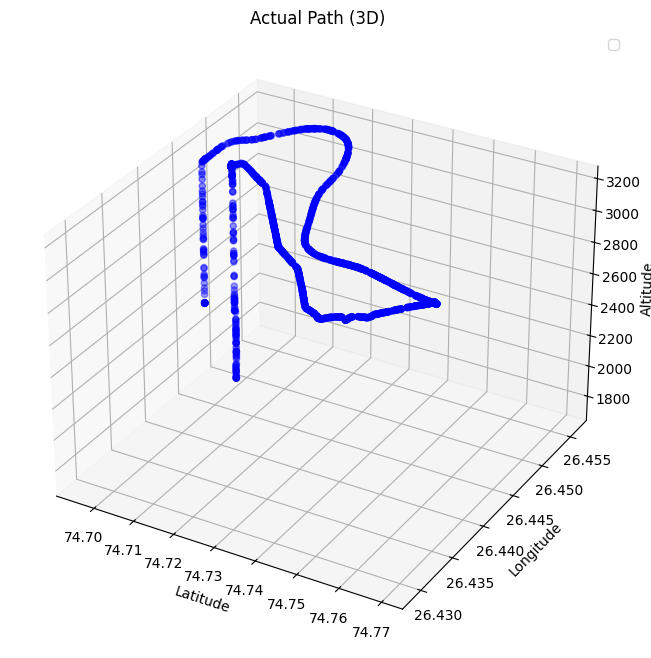

In [33]:
from mpl_toolkits.mplot3d import Axes3D

# ACTUAL PATH IN 3D (Latitude, Longitude, Altitude)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the actual path
#ax.plot(y_test_orig[:, 1], y_test_orig[:, 0], y_test_orig[:, 2], 'b-', label='Actual Path', alpha=0.7)
ax.scatter(y_test_orig[:, 0],y_test_orig[:, 1],  y_test_orig[:, 2], color='b', marker='o')  # Optional scatter for emphasis

# Setting labels and title
ax.set_title('Actual Path (3D)')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')

# Adding legend and grid
ax.legend()
ax.grid(True)

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "actual_3d_path.png")
plt.savefig(filename)
print(f"Plot saved as {filename}")
plt.show()
################################################

# Save the plot
# plt.savefig('actual_3d_path.png')
plt.close()


In [ ]:
'''# ACTUAL VS PREDICTED PATH
plt.figure(figsize=(12, 8))
#plt.plot(y_test_orig[:, 1], y_test_orig[:, 0], 'b-', label='Actual Path', alpha=0.7)
plt.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], 'r--', label='Predicted Path', alpha=0.7)
plt.title(' Predicted Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('predicted.png')
plt.close()'''


C:\Users\Riya Soni\AppData\Local\Temp\ipykernel_25428\2019732123.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Plot saved as c:\Users\Riya Soni\VINESH_JAIN\ANUJ\LSTM-UAV-Trajectory-Path-Prediction\03-11-2024\TrainTestSplit----vala\07-11-2024\08-11-2024_01-18-59\predicted_3d_path.png


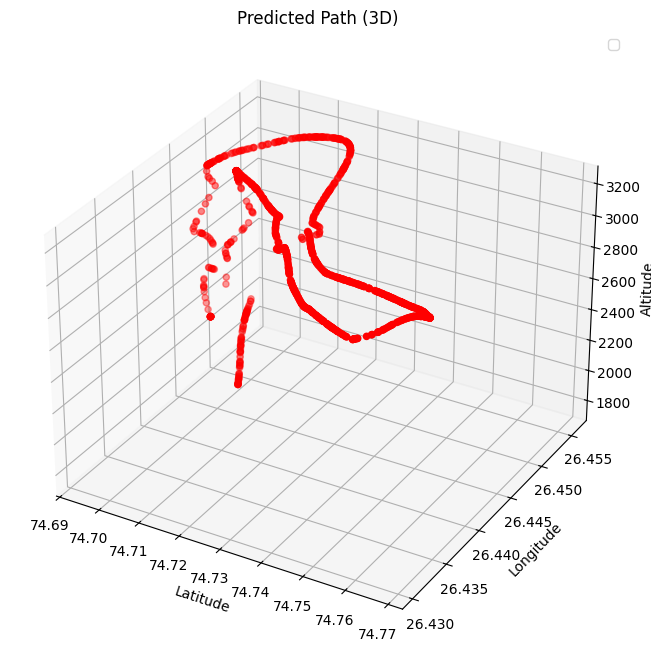

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# PREDICTED PATH IN 3D (Latitude, Longitude, Altitude)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the predicted path
#ax.plot(y_pred_orig[:, 1], y_pred_orig[:, 0], y_pred_orig[:, 2], 'r--', label='Predicted Path', alpha=0.7)
ax.scatter(y_pred_orig[:, 0],y_pred_orig[:, 1], y_pred_orig[:, 2], color='r', marker='o')  # Optional scatter for emphasis

# Setting labels and title
ax.set_title('Predicted Path (3D)')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Altitude')

# Adding legend and grid
ax.legend()
ax.grid(True)

################################################
# Save the plot with the timestamp
# Define the filename within the new directory
filename = os.path.join(output_dir, "predicted_3d_path.png")
plt.savefig(filename)
print(f"Plot saved as {filename}")
plt.show()
################################################

# Save the plot
# plt.savefig('predicted_3d_path.png')
plt.close()
